手写数字加法机----迁移学习
-------

在追求兴趣的道路上，不惧困难，坚持到底

- 蚂蚁还是蜜蜂
- ResNet 与 模型迁移

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
# 从硬盘文件夹中加载图像数据集
# 数据存储总路径
data_dir = "imgdata"
# 图像的大小为224X224像素
image_size = 224
# 从data_dir/train 加载文件
# 加载的过程会对图像进行如下的图像增强操作
# 1、随机从原始的图像中切下来一块224X224大小的区域
# 2、随机水平翻转图像
# 3、将图像的色彩数值标准化
train_dataset = datasets.ImageFolder(os.path.join(data_dir,'train'),
                                    transforms.Compose([
                                        transforms.RandomResizedCrop(image_size),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                    ]))

# 加载校验数据集，对每个加载的数据进行如下处理
# 1、放大到256X256像素
# 2、从中心区域切割下224X224大小的图像区域
# 3、将图像的色彩数值标准化
val_dataset = datasets.ImageFolder(os.path.join(data_dir,'val'),
                                  transforms.Compose([
                                      transforms.Resize(256),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                  ]))
# 创建相应的数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=4,shuffle=True,num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=4,shuffle=True,num_workers=4)

# 读取数据中的分类类别数
num_classes = len(train_dataset.classes)

# 检测本机器是否安装GPU
use_cuda = torch.cuda.is_available()

# 当GPU可用，将新建立的张量自动加载到GPU中
dtype = torch.cuda.FloatTensor if use_cuda else torch.FlotTensor
itpye = torch.cuda.LongTensor if use_cuda else torch.LongTensor

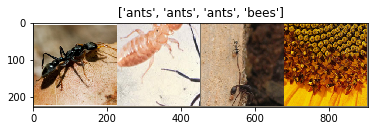

In [3]:
def imshow(inp,title=None):
    # 将一张图打印出来，inp为一个张量，title为显示在图像上的文字
    # 一般张量的格式为:channels*image_width*image_height
    # 而一般的图像为image_width*image_height*channels 所以，需要将channels转换到最后一个维度
    inp = inp.numpy().transpose((1,2,0))
    
    # 由于在读入图像的时候所有图像的色彩都标准化了，因此我们需要先调回去
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    
    # 将图像绘制出来
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 暂停一会儿是为了能够将图像显示出来

# 获取第一个图像batch和标签
images,labels = next(iter(train_loader))

# 将这个batch中的图像绘制成表格绘制出来
out = torchvision.utils.make_grid(images)

imshow(out,title=[train_dataset.classes[x] for x in labels])

加载一个卷积神经网络作为对比
---

In [22]:
depth = [4,8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,4,5,padding=2)
        # 输入通道3，输出为4，窗口大小为5，padding为2
        self.pool = nn.MaxPool2d(2,2)
        # 一个窗口为2的池化运算
        self.conv2 = nn.Conv2d(depth[0],depth[1],5,padding=2)
        self.fc1 = nn.Linear(image_size//4*image_size//4*depth[1],512)
        # 输入尺寸为最后一层立方体的平铺
        self.fc2 = nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor，两次pooling操作，图像维度为原始的1/4
        x = x.view(-1,image_size//4*image_size//4*depth[1])
        x = F.relu(self.fc1(x))
        # 以默认为0.5的概率对这一层进行dropout操作
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)  # log_softmax 可以理解为概率对数值
        return x
    
    # 提取卷积神经网络的特征图函数，返回为前两层卷积层的特征图
    def retrieve_features(self,x):
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1,feature_map2)

""" 计算预测错误率的函数，其中predictions是模型给出的一组预测结果，
    batch_size行10列的矩阵，labels是数据中的正确答案"""
def rightness(predictions,labels):
    # 对于任意一行的输出值的第一个维度求最大，得到每一行最大元素下标
    pred = torch.max(predictions.data,1)[1]
    # 将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    rights = pred.eq(labels.data.view_as(pred)).sum()
    # 返回正确的数量，和这一次一共比较了多少元素
    return rights,len(labels)

In [25]:
# 加载网络
net = ConvNet()
# 如果有GPU就把网络加载到GPU中
net = net.cuda() if use_cuda else net

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=1e-4,momentum=0.9)

# 记录准确率等数值的容器
record = []

num_epochs = 20
# 给网络模型做标记，标志说模型在训练集上训练
net.train(True)
best_model = net
best_r = 0.0
for epoch in range(num_epochs):
    # 记录训练数据集准确率的容器
    train_rights = []
    train_losses = []
    for batch_idx,(data,target) in enumerate(train_loader):
        # 针对容器中每一个批进行循环
        data,target = data.clone().detach().requires_grad_(True),target.clone().detach()
        if use_cuda:
            data,target = data.cuda(),target.cuda()
        
        output = net(data)
        loss = criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        right = rightness(output,target)
        train_rights.append(right)
        
        # 因为所有的计算都在GPU中，打印的数据再加载到CPU中
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())
        
    # train_r 为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]),sum([tup[1] for tup in train_rights]))
    
    # 在测试集上分批运行，并计算总的正确率
    net.eval() # 标志模型为当前运行阶段
    test_loss = 0
    correct = 0
    vals = []
    
    for data,target in val_loader:
        data,target = data.clone().detach().requires_grad_(False),target.clone().detach()
        if use_cuda:
            data,target = data.cuda(),target.cuda()
        
        output = net(data)
        val = rightness(output,target)
        vals.append(val)
        
    # 计算准确率
    val_r = (sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
    val_ratio = 1.0 * val_r[0]/val_r[1]
    
    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    
    # 打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前批的正确率的平均值
    print('训练周期:{} \tLoss:{:.6f}\t训练正确率:{:.2f}%,校验正确率:{:.2f}%'.format(
    epoch,np.mean(train_losses),100.*train_r[0].cpu().numpy()/train_r[1],100.*val_r[0].cpu().numpy()/val_r[1]))
    
    record.append([np.mean(train_losses),train_r[0].cpu().numpy()/train_r[1],val_r[0].cpu().numpy()/val_r[1]])
    

训练周期:0 	Loss:0.689832	训练正确率:50.82%,校验正确率:52.94%
训练周期:1 	Loss:0.676719	训练正确率:59.02%,校验正确率:51.63%
训练周期:2 	Loss:0.654032	训练正确率:61.48%,校验正确率:55.56%
训练周期:3 	Loss:0.646534	训练正确率:59.84%,校验正确率:54.90%
训练周期:4 	Loss:0.639393	训练正确率:58.20%,校验正确率:55.56%
训练周期:5 	Loss:0.630823	训练正确率:59.43%,校验正确率:52.94%
训练周期:6 	Loss:0.634579	训练正确率:58.20%,校验正确率:54.25%
训练周期:7 	Loss:0.631823	训练正确率:59.02%,校验正确率:55.56%
训练周期:8 	Loss:0.611852	训练正确率:62.70%,校验正确率:56.21%
训练周期:9 	Loss:0.612977	训练正确率:61.48%,校验正确率:58.17%
训练周期:10 	Loss:0.631045	训练正确率:61.07%,校验正确率:55.56%
训练周期:11 	Loss:0.609178	训练正确率:63.93%,校验正确率:60.13%
训练周期:12 	Loss:0.620533	训练正确率:61.89%,校验正确率:56.86%
训练周期:13 	Loss:0.606602	训练正确率:61.89%,校验正确率:55.56%
训练周期:14 	Loss:0.617483	训练正确率:64.34%,校验正确率:55.56%
训练周期:15 	Loss:0.609228	训练正确率:59.84%,校验正确率:56.86%
训练周期:16 	Loss:0.608840	训练正确率:61.07%,校验正确率:58.17%
训练周期:17 	Loss:0.608108	训练正确率:60.66%,校验正确率:53.59%
训练周期:18 	Loss:0.589010	训练正确率:65.98%,校验正确率:57.52%
训练周期:19 	Loss:0.599932	训练正确率:65.57%,校验正确率:60.13%


In [29]:
# 在测试集上分批运行，并计算总的正确率
net.eval()  # 标志模型当前为运行阶段
test_loss = 0
correct = 0
vals = []

# 对测试数据集进行循环
for data,target in val_loader:
    data,target = data.clone().detach().requires_grad_(False),target.clone().detach()
    if use_cuda:
        data,target = data.cuda(),target.cuda()
    output = net(data)
    val = rightness(output,target)
    vals.append(val)
    
rights = (sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].cpu().numpy()/rights[1]
right_rate

0.6013071895424836

Text(0, 0.5, 'Error Rate')

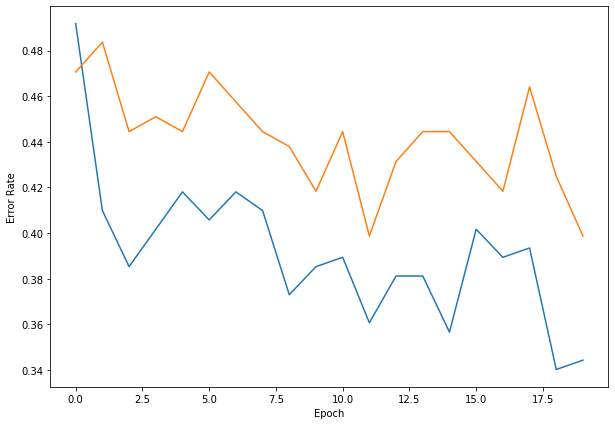

In [30]:
# 绘制误差率曲线
x = [x[0] for x in record]
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]

plt.figure(figsize=(10,7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

Transfer Learning --ResNet18 (预训练模式）
-----

In [4]:
# 加载模型库中的residual network（残差网络）,并设置pretrained为true,这样便可以加载相应的权重
net = models.resnet18(pretrained=True)
net = net.cuda() if use_cuda else net
net

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\焱之杰者/.cache\torch\checkpoints\resnet18-5c106cde.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
""" 计算预测错误率的函数，其中predictions是模型给出的一组预测结果，
    batch_size行10列的矩阵，labels是数据中的正确答案"""
def rightness(predictions,labels):
    # 对于任意一行的输出值的第一个维度求最大，得到每一行最大元素下标
    pred = torch.max(predictions.data,1)[1]
    # 将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    rights = pred.eq(labels.data.view_as(pred)).sum()
    # 返回正确的数量，和这一次一共比较了多少元素
    return rights,len(labels)

In [7]:
# 读取最后线性层的输入单元数，这是前面各层卷积层提取到的特征数量
num_ftrs = net.fc.in_features

# 重新定义一个全新的线性层
net.fc = nn.Linear(num_ftrs,2)

net.fc = net.fc.cuda() if use_cuda else net.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=1e-4,momentum=0.9)

record = []

num_epochs = 20
net.train()  # 给网络做标记，表明模型在训练集上训练
best_model = net
best_r = 0.0

for epoch in range(num_epochs):
    train_rights = []
    train_losses = []
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target = data.clone().detach().requires_grad_(False),target.clone().detach()
        if use_cuda:
            data,target = data.cuda(),target.cuda()
        output = net(data)
        loss = criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        right = rightness(output,target)
        train_rights.append(right)
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())
        
    # train_r 为一个二元组，分别记录训练集中分类正确的数量和集和中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]),sum([tup[1] for tup in train_rights]))
    
    # 在测试集上运行，并计算总的正确率
    net.eval()
    test_loss = 0
    correct = 0
    vals = []
    
    for data,target in val_loader:
        if use_cuda:
            data,target = data.cuda(),target.cuda()
        data,target = data.clone().detach().requires_grad_(True),target.clone().detach()
        
        output = net(data)
        val = rightness(output,target)
        vals.append(val)
        
    val_r = (sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
    val_ratio = 1.0 * val[0] / val[1]
    
    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    print('训练周期:{}\tLoss:{:.6f}\t训练正确率:{:.2f}%,校验正确率:{:.2f}%'.format(
    epoch,np.mean(train_losses),100.*train_r[0].cpu().data.numpy()/train_r[1],
    100.*val_r[0].cpu().data.numpy()/val_r[1]))
    record.append([np.mean(train_losses),train_r[0].cpu().data.numpy()/train_r[1],val_r[0].cpu().data.numpy()/val_r[1]])
    

训练周期:0	Loss:0.694163	训练正确率:56.56%,校验正确率:78.43%
训练周期:1	Loss:0.367140	训练正确率:85.66%,校验正确率:90.85%
训练周期:2	Loss:0.221489	训练正确率:92.62%,校验正确率:88.89%
训练周期:3	Loss:0.177820	训练正确率:93.44%,校验正确率:92.16%
训练周期:4	Loss:0.143432	训练正确率:93.85%,校验正确率:90.20%
训练周期:5	Loss:0.107927	训练正确率:96.72%,校验正确率:91.50%
训练周期:6	Loss:0.113349	训练正确率:95.90%,校验正确率:94.12%
训练周期:7	Loss:0.117880	训练正确率:95.08%,校验正确率:89.54%
训练周期:8	Loss:0.117620	训练正确率:95.08%,校验正确率:91.50%
训练周期:9	Loss:0.115885	训练正确率:95.90%,校验正确率:93.46%
训练周期:10	Loss:0.078494	训练正确率:96.72%,校验正确率:90.85%
训练周期:11	Loss:0.128347	训练正确率:94.67%,校验正确率:90.85%
训练周期:12	Loss:0.081835	训练正确率:96.72%,校验正确率:93.46%
训练周期:13	Loss:0.063208	训练正确率:98.36%,校验正确率:94.12%
训练周期:14	Loss:0.087086	训练正确率:95.90%,校验正确率:93.46%
训练周期:15	Loss:0.049431	训练正确率:99.59%,校验正确率:93.46%
训练周期:16	Loss:0.073953	训练正确率:97.13%,校验正确率:94.12%
训练周期:17	Loss:0.083332	训练正确率:96.72%,校验正确率:94.12%
训练周期:18	Loss:0.064902	训练正确率:97.13%,校验正确率:94.12%
训练周期:19	Loss:0.078740	训练正确率:97.54%,校验正确率:92.81%


Text(0, 0.5, 'Error Rate')

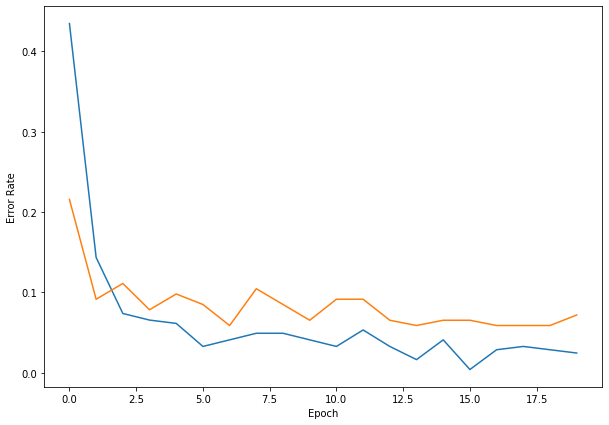

In [8]:
# 打印误差率曲线
x = [x[0] for x in record]
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]

plt.figure(figsize=(10,7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

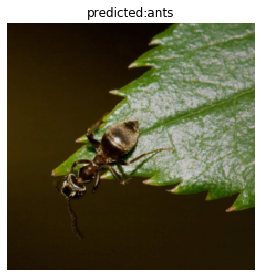

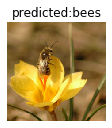

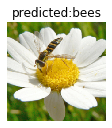

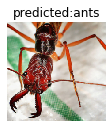

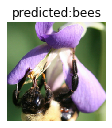

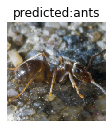

In [18]:
# 将预训练的模型用于测试数据，打印其分类效果
def visualize_model(model,num_images=6):
    image_so_far = 0
    fig = plt.figure(figsize=(20,10))
    
    for i,data in enumerate(val_loader):
        inputs,labels = data
        if use_cuda:
            inputs,labels = inputs.cuda(),labels.cuda()
        outputs = model(inputs)
        _,preds = torch.max(outputs.data,1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        
        for j in range(inputs.size()[0]):
            image_so_far += 1
            ax = plt.subplot(2,num_images//2,image_so_far)
            ax.axis('off')
            ax.set_title('predicted:{}'.format(val_dataset.classes[preds[j]]))
            imshow(data[0][j])
            
            if image_so_far == num_images:
                return

visualize_model(net)

plt.ioff()
plt.show()
        

Transfer Learning --ResNet(固定值模式)
-----

In [7]:
# 加载residual 网络模型
net = models.resnet18(pretrained=True)

net = net.cuda() if use_cuda else net

for params in net.parameters():
    params.requires_grad = False
    
# 将网络最后一层线性层换掉
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs,2)
net.fc = net.fc.cuda() if use_cuda else net.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=1e-3,momentum=0.9)
record = []

num_epochs = 20
net.train()
best_model = net
best_r = 0.0

for epoch in range(num_epochs):
    train_rights = []
    train_losses = []
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target = data.clone().detach().requires_grad_(True),target.clone().detach()
        if use_cuda:
            data,target = data.cuda(),target.cuda()
        output = net(data)
        loss = criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        right = rightness(output,target)
        train_rights.append(right)
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())
        
    train_r = (sum([tup[0] for tup in train_rights]),sum([tup[1] for tup in train_rights]))
    
    # 在测试集上分批运行，并计算总的正确率
    net.eval()
    text_loss = 0
    correct = 0
    vals = []
    
    for data,target in val_loader:
        data,target = data.clone().detach().requires_grad_(False),target.clone().detach()
        if use_cuda:
            data,target = data.cuda(),target.cuda()
        output = net(data)
        val = rightness(output,target)
        vals.append(val)
    
    val_r = (sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0]/val_r[1]
    
    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    print('训练周期:{}\tLoss:{:.6f}\t训练正确率:{:.2f}%,校验正确率:{:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].cpu().data.numpy() / train_r[1], 100. * val_r[0].cpu().numpy()/val_r[1]))
    record.append([np.mean(train_losses), train_r[0].cpu().numpy() / train_r[1], val_r[0].cpu().numpy()/val_r[1]])

训练周期:0	Loss:0.583749	训练正确率:67.21%,校验正确率:86.27%
训练周期:1	Loss:0.253162	训练正确率:88.93%,校验正确率:96.08%
训练周期:2	Loss:0.163914	训练正确率:92.62%,校验正确率:95.42%
训练周期:3	Loss:0.188062	训练正确率:90.57%,校验正确率:93.46%
训练周期:4	Loss:0.168238	训练正确率:91.80%,校验正确率:94.77%
训练周期:5	Loss:0.101798	训练正确率:96.31%,校验正确率:94.12%
训练周期:6	Loss:0.141316	训练正确率:94.26%,校验正确率:95.42%
训练周期:7	Loss:0.108652	训练正确率:96.31%,校验正确率:93.46%
训练周期:8	Loss:0.126224	训练正确率:96.31%,校验正确率:93.46%
训练周期:9	Loss:0.092652	训练正确率:96.31%,校验正确率:95.42%
训练周期:10	Loss:0.107391	训练正确率:96.31%,校验正确率:94.77%
训练周期:11	Loss:0.098357	训练正确率:95.08%,校验正确率:94.77%
训练周期:12	Loss:0.088719	训练正确率:96.31%,校验正确率:94.77%
训练周期:13	Loss:0.092552	训练正确率:95.90%,校验正确率:93.46%
训练周期:14	Loss:0.110879	训练正确率:94.26%,校验正确率:94.12%
训练周期:15	Loss:0.118473	训练正确率:94.67%,校验正确率:93.46%
训练周期:16	Loss:0.096974	训练正确率:96.72%,校验正确率:94.77%
训练周期:17	Loss:0.099806	训练正确率:95.08%,校验正确率:94.12%
训练周期:18	Loss:0.106324	训练正确率:94.26%,校验正确率:93.46%
训练周期:19	Loss:0.092612	训练正确率:96.72%,校验正确率:94.12%


Text(0, 0.5, 'Error Rate')

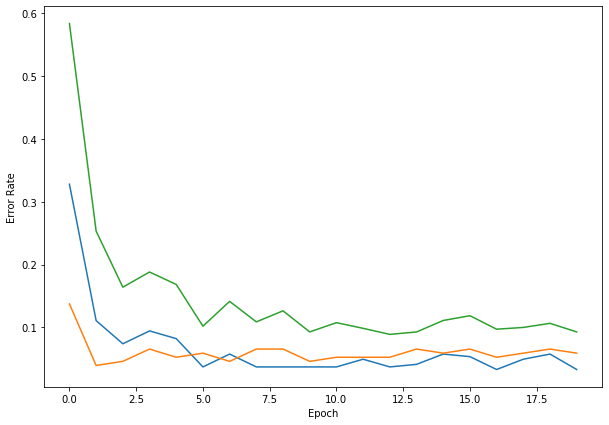

In [16]:
x = [x[0] for x in record]
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]
plt.figure(figsize=(10,7))
plt.plot(y)
plt.plot(z)
plt.plot(x)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

In [87]:
file_path = r"G:\ee"
image_test = datasets.ImageFolder(os.path.join(file_path,'ww'),
                                 transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                 ]))
print(image_test)

Dataset ImageFolder
    Number of datapoints: 6
    Root location: G:\ee\ww
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


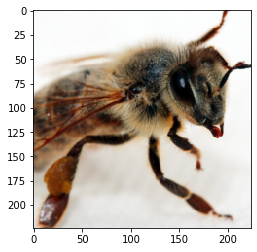

[1]


In [62]:
data = image_test[0][0].unsqueeze(0).cuda()
pred = best_model(data)
_,preds = torch.max(pred.data,1)
preds = preds.cpu().data.numpy()
imshow(image_test[0][0])
print(preds)

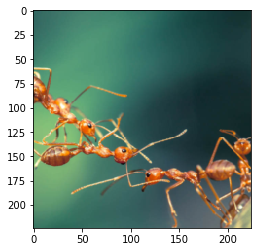

[0]


In [67]:
data = image_test[1][0].unsqueeze(0).cuda()
output = best_model(data)
_,pred = torch.max(output.data,1)
imshow(image_test[1][0])
print(pred.cpu().data.numpy())

[1]


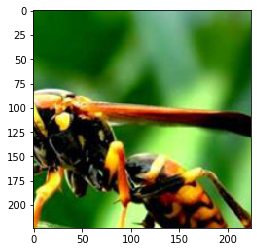

In [91]:
tiger = image_test[5][0].unsqueeze(0)
out = best_model(tiger.cuda() if use_cuda else tiger)
_,pred = torch.max(out.data,1)
print(pred.cpu().numpy())
imshow(image_test[5][0])